Adapted from [https://github.com/PacktPublishing/Bioinformatics-with-Python-Cookbook-Second-Edition](https://github.com/PacktPublishing/Bioinformatics-with-Python-Cookbook-Second-Edition), Chapter 2.

```
conda config --add channels bioconda
conda install tabix pyvcf
```
You can also check the functions available in `scikit-allel` [here](http://alimanfoo.github.io/2017/06/14/read-vcf.html)

Example of VCF file. Nice explanation by Colleen Saunders can be found [here](https://training.h3abionet.org/IBT_2017/wp-content/uploads/2017/06/Module5_Session4_part3.mp4):


```
##fileformat=VCFv4.3
##reference=file:///seq/references/1000GenomesPilot-NCBI36.fasta
##contig=<ID=20,length=62435964,assembly=B36,md5=f126cdf8a6e0c7f379d618ff66beb2da,species="Homo sapiens",taxonomy=x>
##INFO=<ID=DP,Number=1,Type=Integer,Description="Total Depth">
##INFO=<ID=AF,Number=A,Type=Float,Description="Allele Frequency">
##INFO=<ID=DB,Number=0,Type=Flag,Description="dbSNP membership, build 129">
##FILTER=<ID=q10,Description="Quality below 10">
##FILTER=<ID=s50,Description="Less than 50% of samples have data">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Read Depth">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	NA00001	NA00002	NA00003
20	14370	rs6054257	G	A	29	PASS	DP=14;AF=0.5;DB	GT:DP	0/0:1	0/1:8	1/1:5
20	17330	.	T	A	3	q10	DP=11;AF=0.017	GT:DP	0/0:3	0/1:5	0/0:41
20	1110696	rs6040355	A	G,T	67	PASS	DP=10;AF=0.333,0.667;DB	GT:DP	0/2:6	1/2:0	2/2:4
20	1230237	.	T	.	47	PASS	DP=13	GT:DP	0/0:7	0/0:4	./.:.

```

# Getting the necessary data

You just need to do this only once

In [3]:
!rm -f data/genotypes.vcf.gz 2>/dev/null
!tabix -fh ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20130502/supporting/vcf_with_sample_level_annotation/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5_extra_anno.20130502.genotypes.vcf.gz 22:1-17000000|bgzip -c > data/genotypes.vcf.gz
!tabix -p vcf data/genotypes.vcf.gz

In [2]:
from collections import defaultdict

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import vcf

Variant record level

* AC: total number of alternative allelels in called genotypes
* AF: estimated allele frequency
* NS: number of samples with data
* AN: total number of alleles in called genotypes
* DP: total read depth
* (...)

Sample level:

* GT: genotype
* DP: per sample read depth

In [9]:
v = vcf.Reader(filename='data/genotypes.vcf.gz')

print('Variant Level information')
infos = v.infos
for info in infos:
    print(info)

print('Sample Level information')
fmts = v.formats
for fmt in fmts:
    print(fmt)

Variant Level information
CIEND
CIPOS
CS
END
IMPRECISE
MC
MEINFO
MEND
MLEN
MSTART
SVLEN
SVTYPE
TSD
AC
AF
NS
AN
ASN_AF
EUR_AF
AFR_AF
AMR_AF
SAN_AF
DP
Sample Level information
GT
DP


Let us inspect a single VCF record

In [6]:
v = vcf.Reader(filename='data/genotypes.vcf.gz')
rec = next(v)
print('=====\nCHROM, POS, ID, REF, ALT, QUAL, FILTER' )
print(rec.CHROM, rec.POS, rec.ID, rec.REF, rec.ALT, rec.QUAL, rec.FILTER)
print('=====\nVariant-level info')
print(rec.INFO)
print(rec.FORMAT)
print('=====\nSAMPLE ID\'s')
samples = rec.samples
print(len(samples))
sample = samples[0]
print(sample.called, sample.gt_alleles, sample.is_het, sample.is_variant, sample.phased)
print(int(sample['DP']))

=====
CHROM, POS, ID, REF, ALT, QUAL, FILTER
22 16050075 None A [G] 100 []
=====
Variant-level info
{'AC': [1], 'AF': [0.000199681], 'AN': 5008, 'NS': 2504, 'DP': [8012], 'ASN_AF': [0.0], 'AMR_AF': [0.0], 'SAS_AF': ['0.0010'], 'EUR_AF': [0.0], 'EAS_AF': [''], 'AFR_AF': [0.0], 'SAN_AF': [0.0]}
GT:DP
=====
SAMPLE ID's
2504
True ['0', '0'] False False True
1


let us check the type of variant and the number onbiallelic SNPs

In [10]:
f = vcf.Reader(filename='data/genotypes.vcf.gz')

my_type = defaultdict(int)
num_alts = defaultdict(int)

for rec in f:
    my_type[rec.var_type, rec.var_subtype] += 1
    if rec.is_snp:
        num_alts[len(rec.ALT)] += 1
print(my_type)
print(num_alts)

defaultdict(<class 'int'>, {('snp', 'ts'): 10054, ('snp', 'tv'): 5917, ('sv', 'CNV'): 2, ('indel', 'del'): 273, ('snp', 'unknown'): 79, ('indel', 'ins'): 127, ('indel', 'unknown'): 13, ('sv', 'DEL'): 6, ('sv', 'SVA'): 1})
defaultdict(<class 'int'>, {1: 15971, 2: 79})


![alt text](figures/TTs.png "Title")

In [11]:
f = vcf.Reader(filename='data/genotypes.vcf.gz')

sample_dp = defaultdict(int)
for rec in f:
    if not rec.is_snp or len(rec.ALT) != 1:
        continue
    for sample in rec.samples:
        dp = sample['DP']
        if dp is None:
            dp = 0
        dp = int(dp)
        sample_dp[dp] += 1

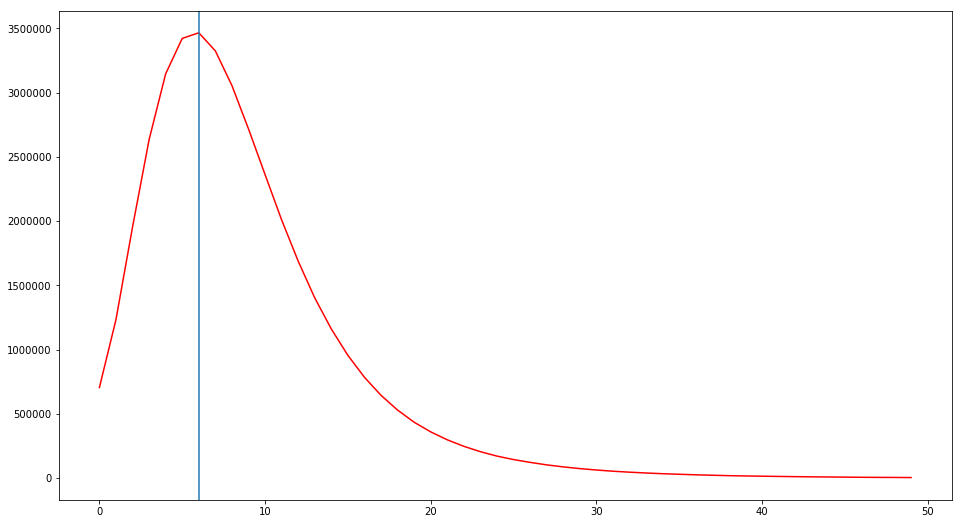

In [12]:
dps = list(sample_dp.keys())
dps.sort()
dp_dist = [sample_dp[x] for x in dps]
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(dp_dist[:50], 'r')
ax.axvline(dp_dist.index(max(dp_dist)))